In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import sys
import matplotlib.pylab as pylab
import time
import numpy as np
import seaborn as sns
sns.set_theme(style="white")
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import yaml
import os
import pandas as pd
from scipy.stats import mannwhitneyu


new_directory = '/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/'
os.chdir(new_directory)
from src.utils import *
import src.utils as ut

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 25,
         'axes.titlesize':25,
         'xtick.labelsize':25,
         'ytick.labelsize':25}
pylab.rcParams.update(params)

PATH2 = ''

In [2]:
import gzip 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

PATH = '/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/'

def test_gpus():
    print(torch.cuda.is_available())
    print(torch.__version__)

def load_data_to_train(): 
    data_path = ('/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/data/time_series/real/OGLE3_lcs_I_meta_snr5_augmented_folded_trim600.npy.gz')
    print('Loading from:\n', data_path)
    with gzip.open(data_path, 'rb') as f:
        np_data = np.load(f, allow_pickle=True)
    return np_data.item()['meta'], np_data.item()['lcs'], np_data

def save_data(meta, lcs, data,
    data_path = 'data/time_series/real/OGLE3_lcs_I_meta_snr5_augmented_folded_trim600_GAIA3_6PP.npy.gz'):
    print('Saving to:\n', data_path)
    data.item()['meta'] = meta
    data.item()['lcs'] = lcs
    with gzip.open(data_path, 'wb') as f:
        np.save(f, data)    
    print('Data saved successfully.')

def load_new_validated_pp():
    pp_path = '/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/data/inter/Validated_OGLExGaiaDR3.csv'
    df = pd.read_csv(pp_path)
    return df

def remove_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return [x for x in data if lower_bound <= x <= upper_bound]


def compare_frequency(s1, s2, s3, feature = "Period", clean = True): 
    
    if clean:
        s1 = remove_outliers(s1)
        s2 = remove_outliers(s2)
        s3 = remove_outliers(s3)

    plt.figure(figsize=(5,5))

    # Plot histograms
    plt.hist(s1, bins=100, alpha=0.5, label=feature +' 1')
    plt.hist(s2, bins=100, alpha=0.5, label= feature +' 2')
    plt.hist(s3, bins=100, alpha=0.5, label='Final ' + feature)

    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.title('Comparison of Histograms')
    plt.show()


def basic_histogram(s1, title='Delta of Teff'): 
    plt.figure(figsize=(5,5))

    # Plot histograms
    plt.hist(s1, bins=50, alpha=0.5)

    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

def update_values(df, feature="teff_val"):
    condition_orig_is_nan = df[feature+'_orig'].isna()
    condition_new_is_nan = df[feature+'_new'].isna()

    df[feature] = np.where(
        condition_orig_is_nan, 
        df[feature+'_new'],
        np.where(condition_new_is_nan, df[feature+'_orig'], df[feature+'_new'])
    )

    return df

def plot_2d_density(df_train, df_test, star_class='CEP', sample=0, xlim=(0,20), bw=0.5):
    selected_features = ['PeriodLS', 'Amplitude']#, 'MedianAbsDev', 'Q31', 'Mean', 'Std', 'Freq1_harmonics_amplitude_0']
    print(df_train[(df_train.Type==star_class)].shape)
    print(df_test[(df_test.Type==star_class)].shape)


    d_train = df_train[(df_train.Type==star_class)][selected_features]
    d_test = df_test[(df_test.Type==star_class)][selected_features]

    if sample<d_train.shape[0]: 
        d_train = d_train.sample(sample)
    #d_train['PeriodLS'] = np.log(d_train['PeriodLS'])
    #d_test['PeriodLS'] = np.log(d_test['PeriodLS'])



    print(d_train.PeriodLS.min(), d_test.PeriodLS.max())
    d_train['set'] = 'Training set'
    d_test['set'] =  'Testing set'
    data_final = pd.concat([d_train, d_test])
    data_final.columns = ['Period (days)', 'Amplitude', 'set']
    sns.set_theme(style="white")

    sns.set_context("paper", rc={"font.size":14, "font_scale":1.25, "axes.titlesize":14,"axes.labelsize":14,
                    "xtick.labelsize":14, "ytick.labelsize":14, "legend.fontsize":12, "legend.title_fontsize": 14, 
                                "legend.loc": 'upper center', "alpha":0.1, "figure.dpi":600, 'savefig.dpi':600}) 

    plt.figure(figsize=(25, 25), dpi = 900) 
    g = sns.PairGrid(data_final, hue='set', palette = 'colorblind', corner=True)
    g.map_diag(sns.kdeplot,  shade=True, palette = 'colorblind')
    g.map_lower(sns.kdeplot, palette = 'colorblind')
    g.map_upper(sns.kdeplot, shade=True, palette = 'colorblind', hue=None)

    
    g.axes[1,0].set_xlim(xlim)
    '''
    g.axes[1,0].set_ylim((0,1.2))

    g.axes[1,0].set_yticks([0, 0.2,0.4,0.6,0.8,1])
    g.axes[1,0].set_xticks([0, 0.5 ,1])
    '''
    handles = g._legend_data.values()
    labels = g._legend_data.keys()
    plt.legend(handles=handles, labels=labels, loc='upper left', bbox_to_anchor=(0, 1.8), ncol=1)
    plt.savefig('lpv-period-amplitude.svg', format='svg', dpi=300, bbox_inches='tight')
    

def plot_2d_scatter(df_train, df_test, star_class='CEP', sample=0, xlim=(0,20), bw=0.5):
    selected_features = ['PeriodLS', 'Amplitude']
    print(df_train[(df_train.Type == star_class)].shape)
    print(df_test[(df_test.Type == star_class)].shape)

    d_train = df_train[(df_train.Type == star_class)][selected_features]
    d_test = df_test[(df_test.Type == star_class)][selected_features]

    if sample > 0 and sample < d_train.shape[0]: 
        d_train = d_train.sample(sample)

    print(d_train.PeriodLS.min(), d_test.PeriodLS.max())
    d_train['set'] = 'Training set'
    d_test['set'] = 'Testing set'
    data_final = pd.concat([d_train, d_test])
    data_final.columns = ['Period (days)', 'Amplitude', 'set']

    sns.set_theme(style="white")
    sns.set_context("paper", rc={"font.size":14, "font_scale":1.25, "axes.titlesize":14, "axes.labelsize":14,
                                 "xtick.labelsize":14, "ytick.labelsize":14, "legend.fontsize":12, "legend.title_fontsize":14, 
                                 "legend.loc": 'upper center', "alpha":0.1, "figure.dpi":600, 'savefig.dpi':600})

    plt.figure(figsize=(25, 25), dpi=900) 
    g = sns.PairGrid(data_final, hue='set', palette='colorblind', corner=True)
    g.map_diag(sns.histplot)
    g.map_lower(sns.scatterplot)
    g.map_upper(sns.kdeplot, shade=True, bw_adjust=bw)

    # Set the x-axis limit for the lower scatter plot
    g.axes[1, 0].set_xlim(xlim)

    handles = g._legend_data.values()
    labels = g._legend_data.keys()
    plt.legend(handles=handles, labels=labels, loc='upper left', bbox_to_anchor=(0, 1.8), ncol=1)
    plt.savefig('lpv-period-amplitude.svg', format='svg', dpi=300, bbox_inches='tight')

# Example usage (assuming df_train and df_test are defined DataFrames):
# plot_2d_scatter(df_train, df_test, star_class='CEP', sample=100, xlim=(0, 5), bw=0.5)



    
def split_id_ogle(df): 

    df['ID'] = df['ID'].str.replace('.dat', '', regex=False)
    # 2. Split by '-' and expand into separate columns
    split_df = df['ID'].str.split('-', expand=True)

    # Assign the split columns to new dataframe columns
    df['Survey'] = split_df[0]
    df['Field'] = split_df[1]
    df['Type'] = split_df[2]
    df['ID_number'] = split_df[3]
    return df

def test_manhwhitneyu(train_dataset, test_dataset): 
    for star_class in ['LPV', 'CEP', 'RRLYR', 'ECL', 'DSCT']:
        print(star_class)
        df1 = train_dataset[(train_dataset.Type==star_class)][['Amplitude', 'PeriodLS']]
        df2 = test_dataset[(test_dataset.Type==star_class)][['Amplitude', 'PeriodLS']]

        if star_class=='DSCT': 
            df1 = df1[df1.PeriodLS<1] #To delete two atypical stars with very large periods

        print('n used in training: ', df1.shape[0], 'n used in testing: ', df2.shape[0])
        # Perform Mann-Whitney U test
        stat, p = mannwhitneyu(df1['Amplitude'], df2['Amplitude'])

        print('means: ', df1['Amplitude'].mean(), df2['Amplitude'].mean())
        print('std: ', df1['Amplitude'].std(), df2['Amplitude'].std())
        print('Amplitude, Statistics=%.4f, p=%.4f' % (stat, p))

        # Interpret the result
        alpha = 0.05  # or your chosen alpha level
        if p > alpha:
            print('Same distribution (fail to reject H0)')
        else:
            print('Different distribution (reject H0)')



        stat, p = mannwhitneyu(df1['PeriodLS'], df2['PeriodLS'])
        print('Period, Statistics=%.4f, p=%.4f' % (stat, p))
        print('means: ', df1['PeriodLS'].mean(), df2['PeriodLS'].mean())
        print('std: ', df1['PeriodLS'].std(), df2['PeriodLS'].std())

        # Interpret the result
        alpha = 0.05  # or your chosen alpha level
        if p > alpha:
            print('Same distribution (fail to reject H0)')
        else:
            print('Different distribution (reject H0)')
    
def delete_outliers(train_dataset, test_dataset):
    """
    Remove outliers from train and test datasets based on z-scores.

    Parameters:
        train_dataset (pd.DataFrame): Training dataset with a 'label' column.
        test_dataset (pd.DataFrame): Testing dataset with a 'label' column.

    Returns:
        tuple: The cleaned train and test datasets without outliers.
    """
    # Isolate and remove the label column from the training dataset
    train_label = train_dataset.pop('label')
    # Standardize the training dataset and compute z-scores
    train_dataset_z = (train_dataset - train_dataset.mean()) / train_dataset.std()
    filtered_entries_train = (np.abs(stats.zscore(train_dataset_z)) < 6).all(axis=1)
    train_dataset['label'] = train_label
    train_dataset = train_dataset[filtered_entries_train]

    # Isolate and remove the label column from the testing dataset
    test_label = test_dataset.pop('label')
    # Standardize the testing dataset and compute z-scores
    test_dataset_z = (test_dataset - test_dataset.mean()) / test_dataset.std()
    filtered_entries_test = (np.abs(stats.zscore(test_dataset_z)) < 6).all(axis=1)
    test_dataset['label'] = test_label
    test_dataset = test_dataset[filtered_entries_test]

    return train_dataset, test_dataset

In [6]:
with open('src/configuration/paths.yaml', 'r') as file:
    YAML_FILE = yaml.safe_load(file)

PATHS =YAML_FILE['paths']

print(PATHS)

PATH_FEATURES_TRAIN = "/home/franciscoperez/Documents/GitHub/data/BIASEDFATS/Train_rrlyr-1.csv" #PATHS['PATH_FEATURES_TRAIN']
PATH_FEATURES_TEST = "/home/franciscoperez/Documents/GitHub/data/BIASEDFATS/Test_rrlyr-1.csv" # PATHS['PATH_FEATURES_TEST']

PATH2 = PATHS['PATH_LIGHT_CURVES_OGLE']

lc_test = pd.read_table(PATH_FEATURES_TEST, sep= ',')
print(lc_test)
lc_test = lc_test[lc_test.label=='ClassA']
lc_train = pd.read_table(PATH_FEATURES_TRAIN, sep= ',')
lc_train = lc_train[lc_train.label=='ClassA']

{'PATH_PRIOS': 'src/gmm/priors.yaml', 'PATH_PP': '/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/data/metadata_updated_0823.csv', 'PATH_LIGHT_CURVES_OGLE': '/home/franciscoperez/Desktop/Code/FATS/LCsOGLE/data/', 'PATH_FEATURES_TRAIN': '/home/franciscoperez/Documents/GitHub/data/BIASEDFATS/train_OGLEDR3_T_3.csv', 'PATH_FEATURES_TEST': '/home/franciscoperez/Documents/GitHub/data/BIASEDFATS/test_OGLEDR3_T_3.csv', 'PATH_NUMPY_DATA_X_TRAIN': 'data/train_np_array.npy', 'PATH_NUMPY_DATA_X_TEST': 'data/test_np_array.npy', 'PATH_NUMPY_DATA_Y_TRAIN': 'data/train_np_array_y.npy', 'PATH_NUMPY_DATA_Y_TEST': 'data/test_np_array_y.npy', 'PATH_SUBCLASSES': '/home/franciscoperez/Documents/GitHub/vsbms_multiple_classes/bayesianMLP/src/data/all_subclasses', 'PATH_DATA_FOLDER': '/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/data', 'PATH_COLAB_ROOT': '/content/drive/My Drive/Colab_Notebooks/data', 'PATH_EXALEARN_ROOT': '/home/user/data', 'PATH_MODELS': '/home/franciscoper

In [7]:
example_test  = lc_test['ID'].sample(20)
example_train = lc_train['ID'].sample(20)

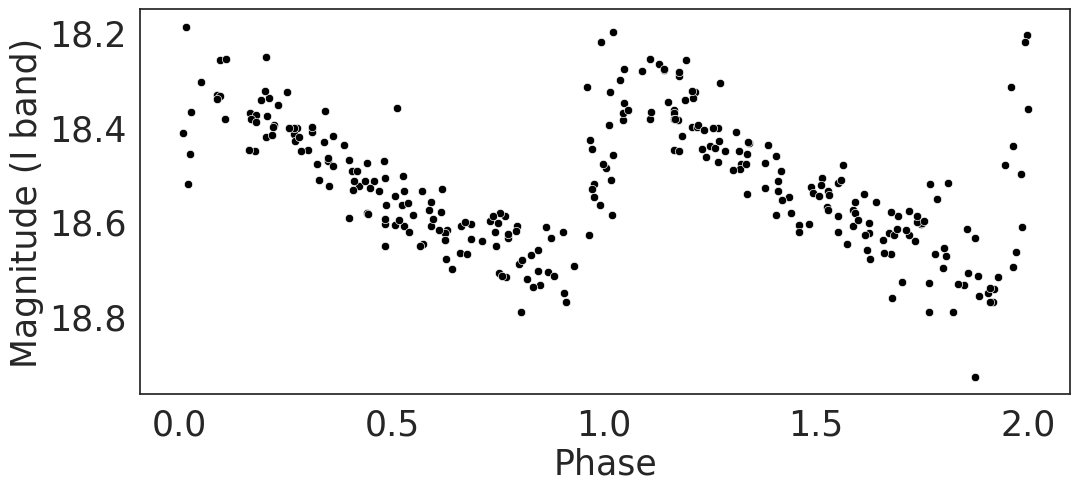

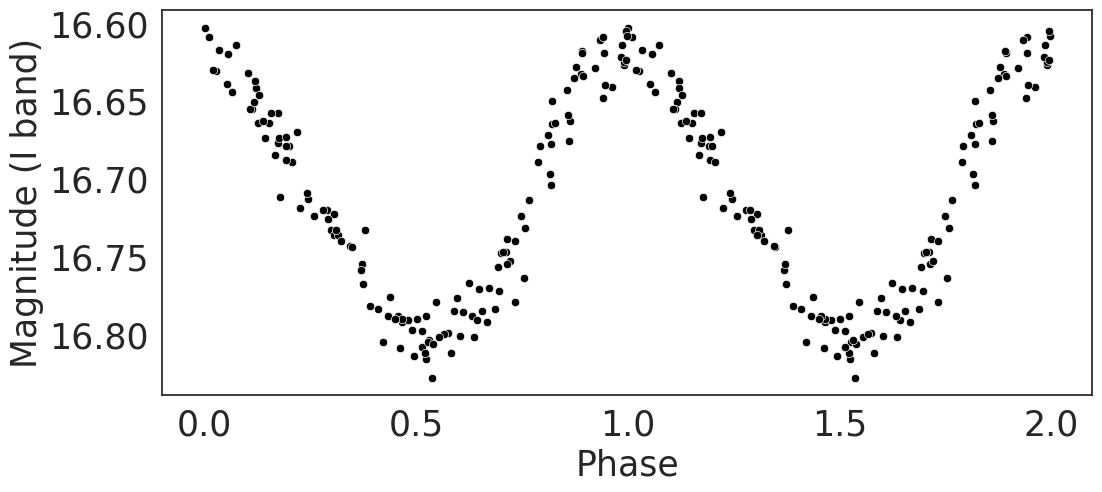

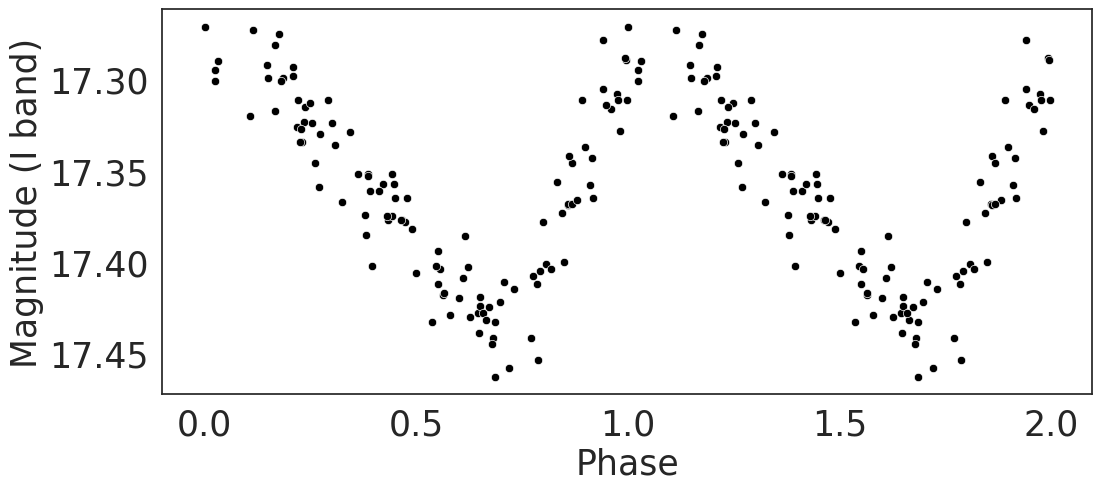

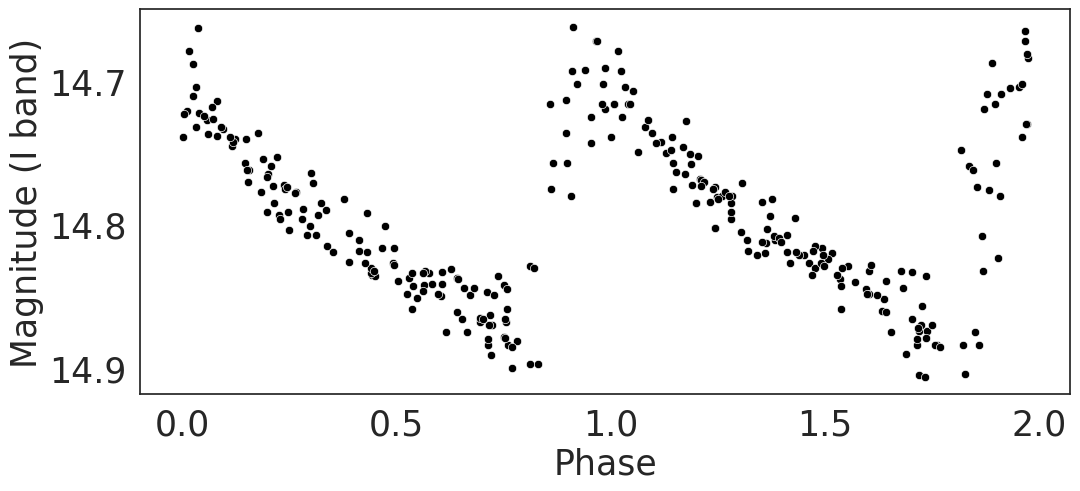

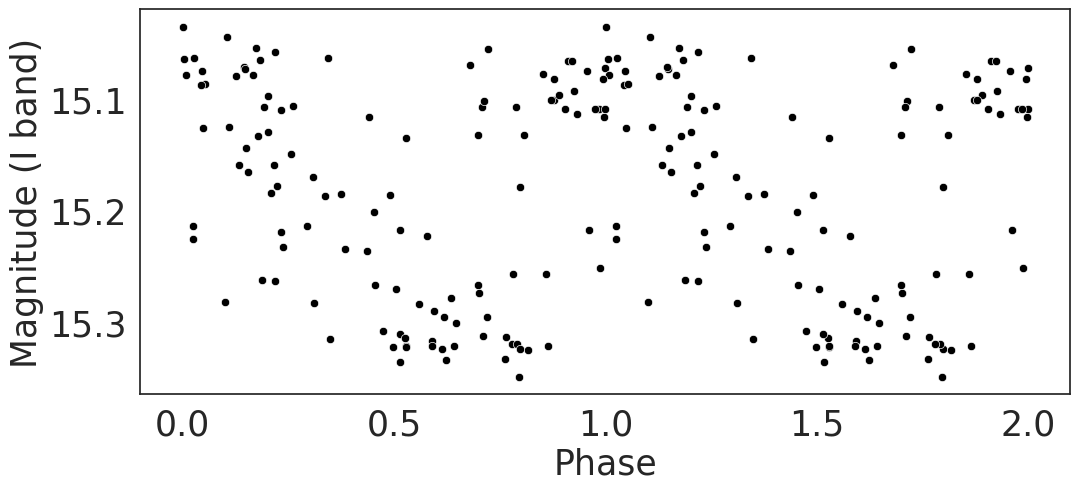

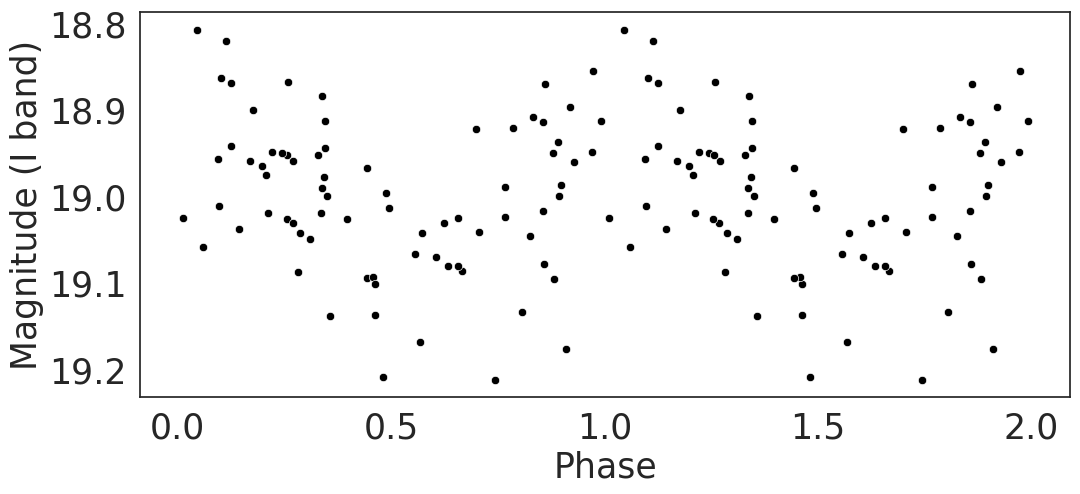

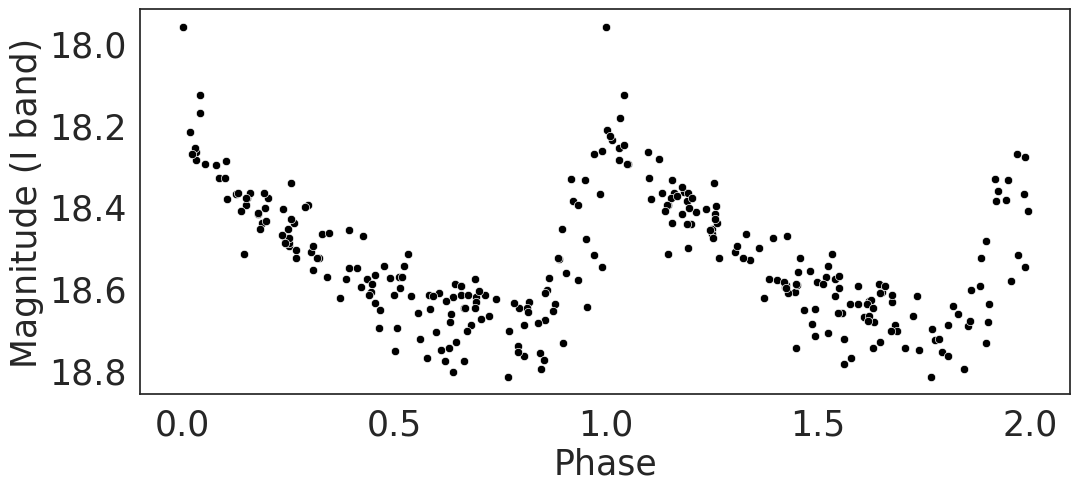

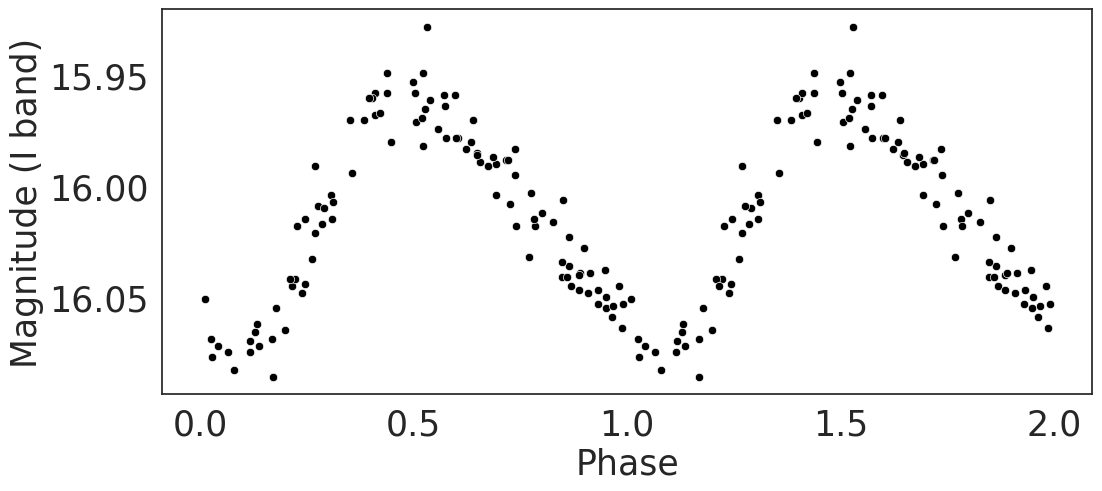

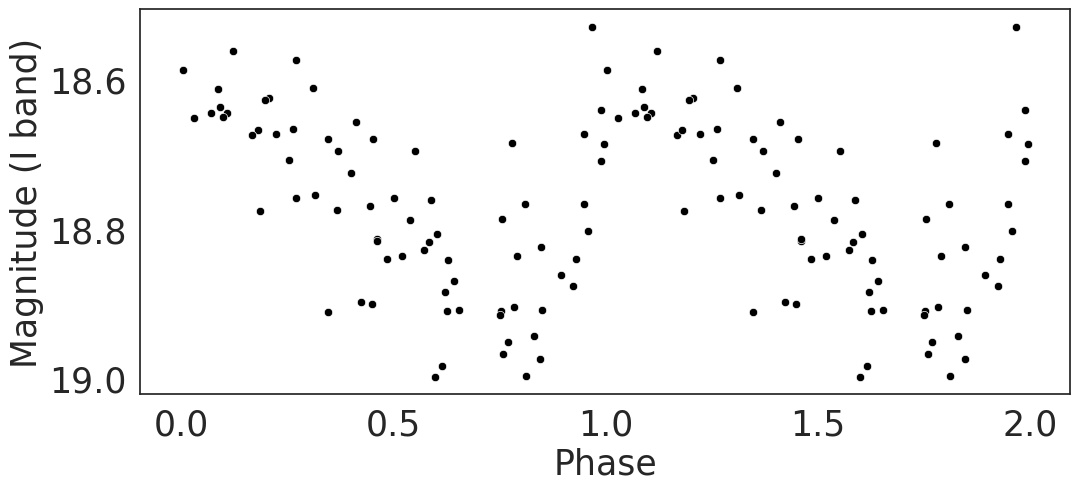

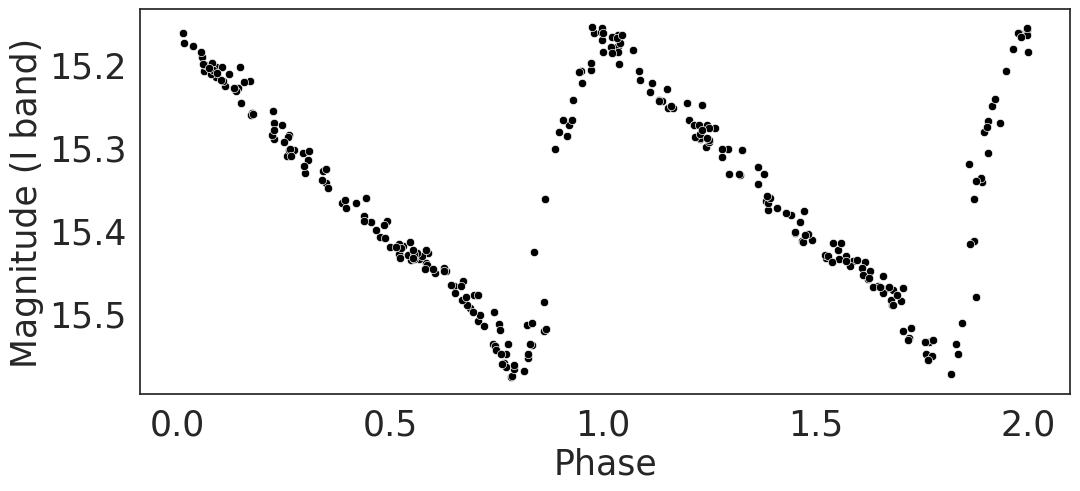

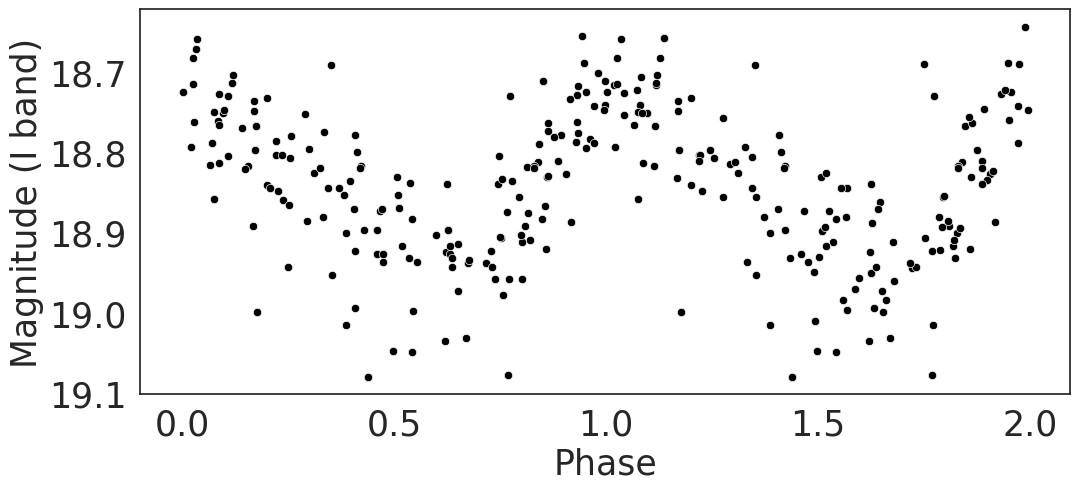

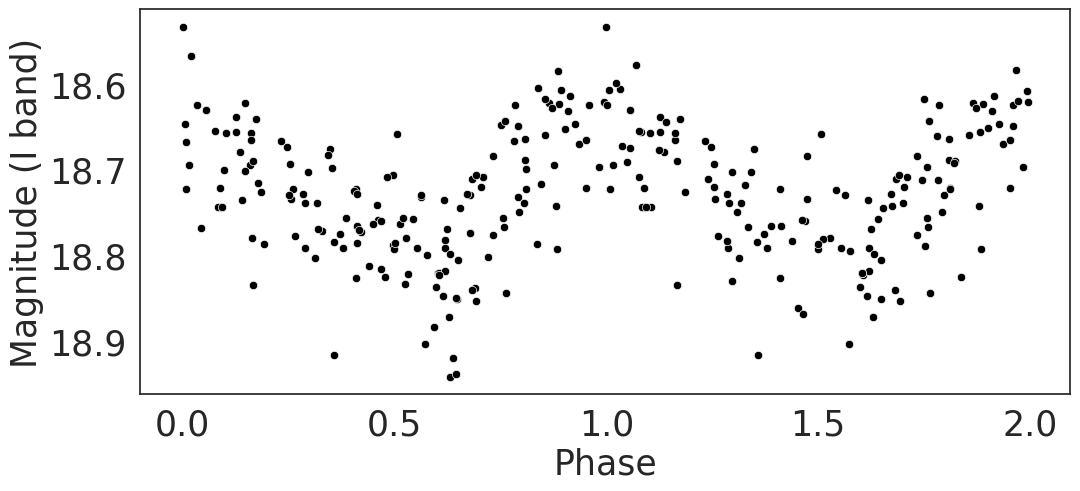

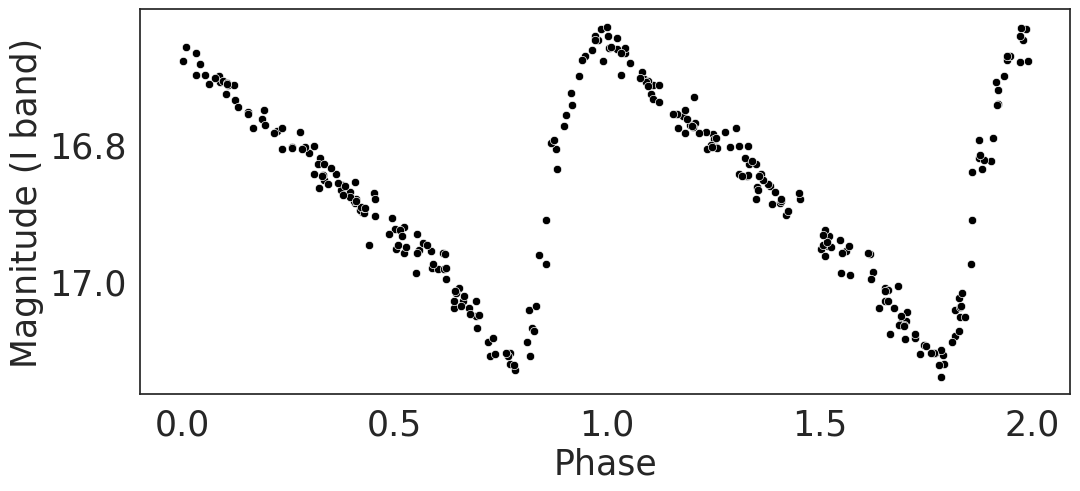

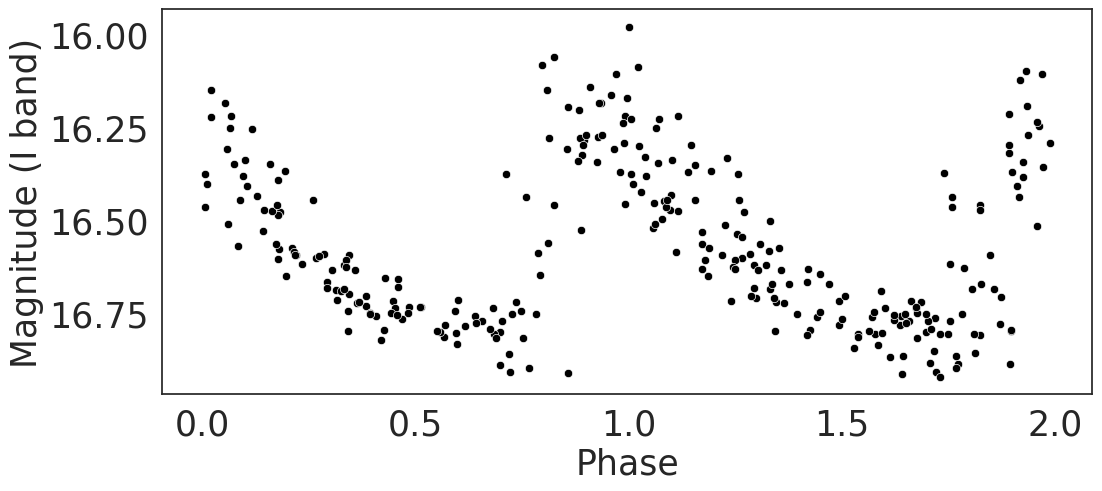

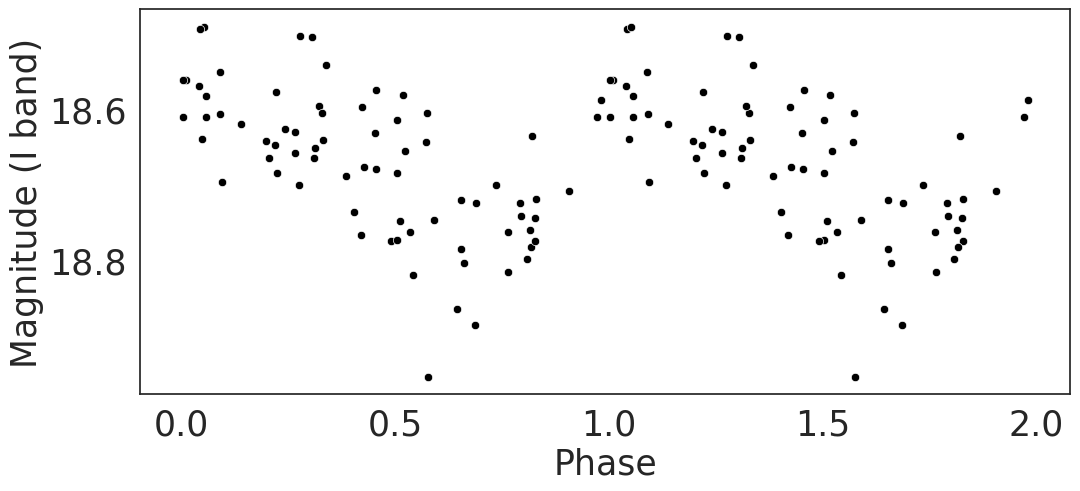

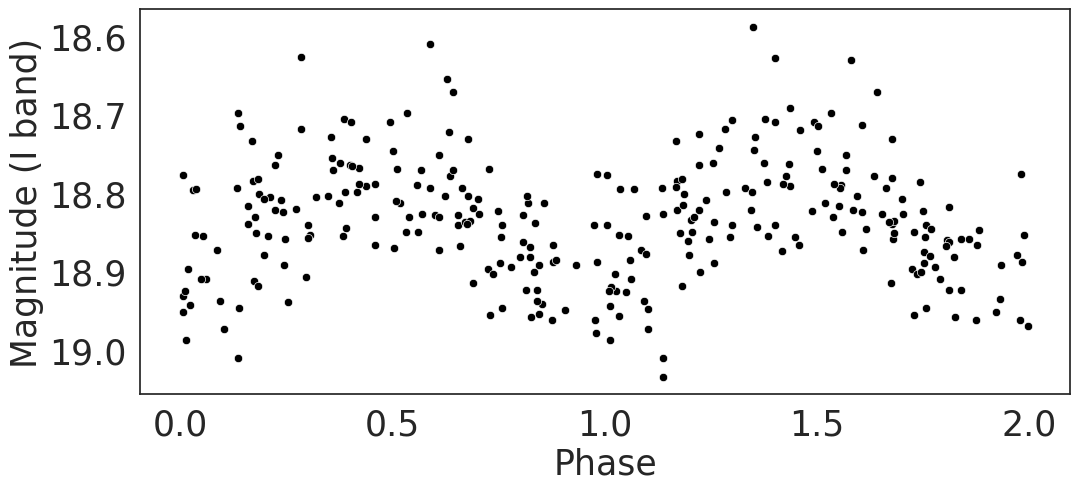

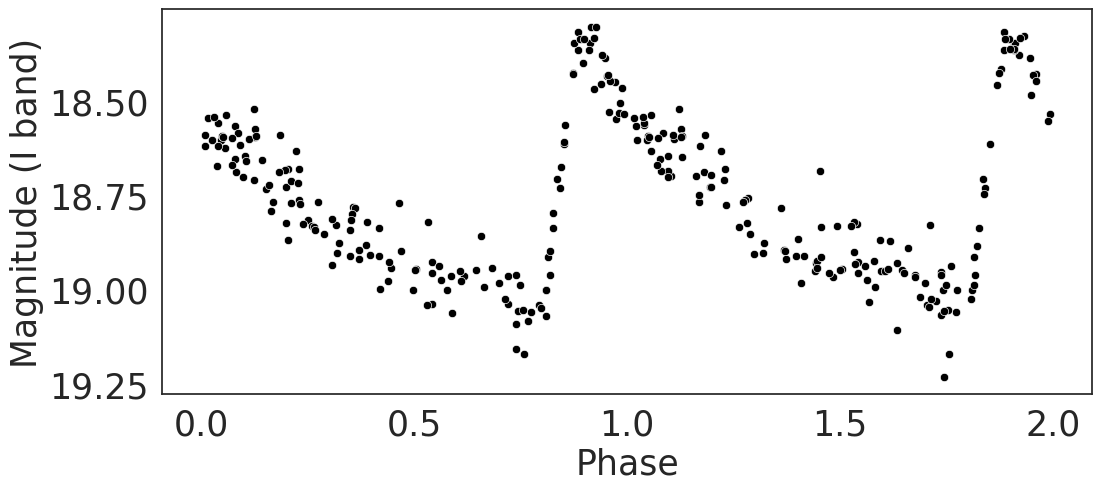

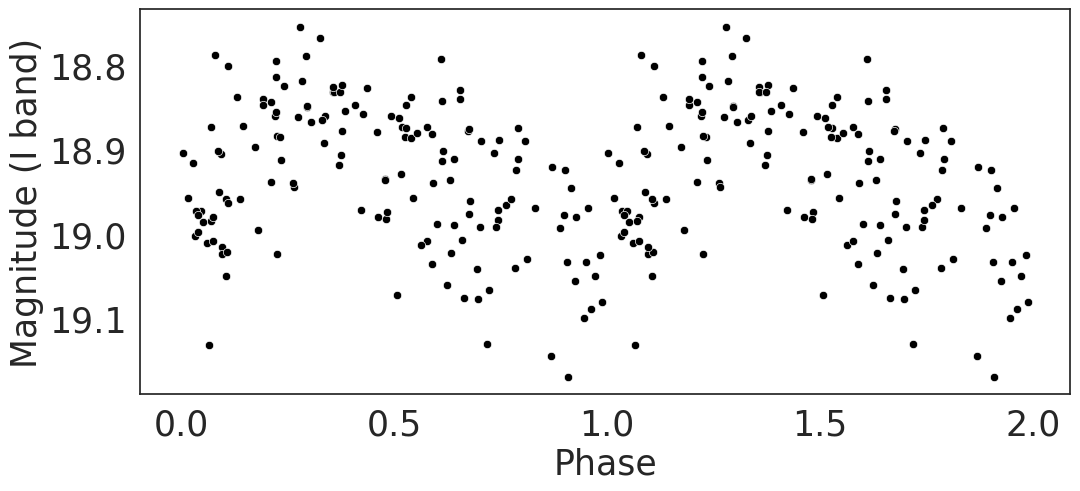

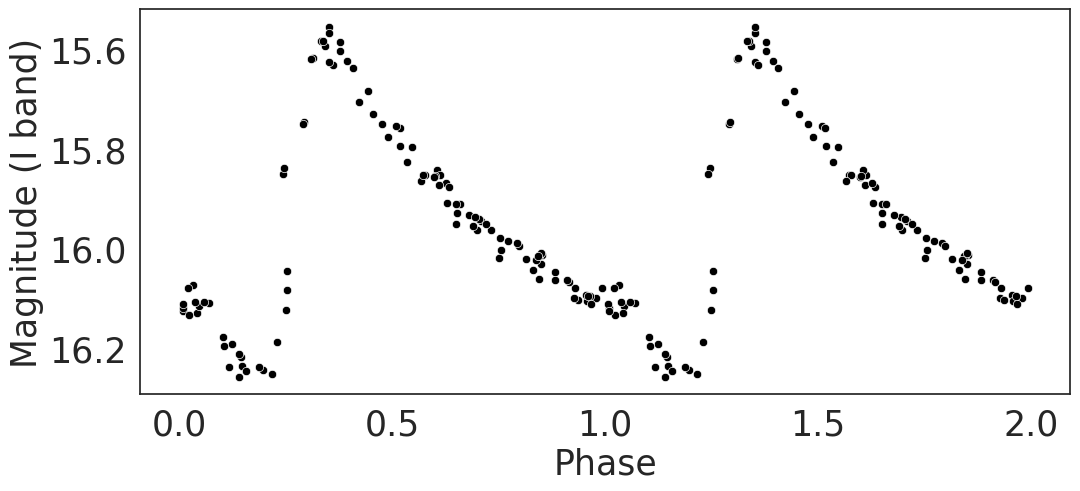

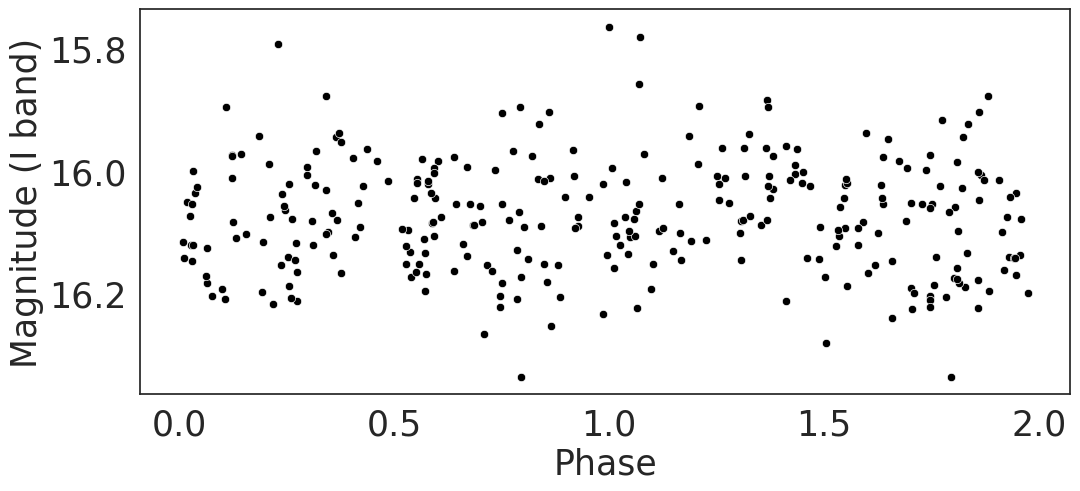

In [14]:
counter = 1 

for lc in example_test.unique():
    try:
        new_test = lc_test[lc_test.ID==lc].ID.str.split("-", n = 3, expand = True)
        
        period = lc_test[lc_test.ID==lc].PeriodLS.values[0]
        field = new_test[new_test.columns[1]].values[0].lower()
        
        lcu = pd.read_table(PATH2+field+'/'+lc.split('-')[2].lower()+'/phot/I/'+lc,sep=" ", names=['time', 'magnitude', 'error'])
        
        m0 = lcu.magnitude.min()
        t0 = lcu[lcu.magnitude==m0].time.min()
        lcu['Phase'] = ((lcu.time-t0)/period)%1 
        lcu = lcu.dropna()

        lcu2 =  lcu.copy()
        lcu2['Phase'] = lcu2['Phase']+1
        lcu = pd.concat([lcu,lcu2])
        sample = 300
        if lcu.dropna().shape[0]<300: 
            sample=lcu.dropna().shape[0]
        fig, ax=plt.subplots(figsize=(12, 5))
        sns.scatterplot(x="Phase", y="magnitude",
                 data=lcu.dropna().sample(sample), alpha =1.0, color='black', palette = 'black')
        #plt.title( str(lc).replace('.dat', '') + ', Period ' + str(np.round(period,2)) + ' days')
        plt.ylabel('Magnitude (I band)')

        ax.invert_yaxis()
        plt.savefig('test'+str(counter)+'.svg', format='svg', bbox_inches='tight')
        counter = counter + 1

    except Exception as error:
        print(error)

In [ ]:
test_dataset = pd.read_table(PATH_FEATURES_TEST, sep= ',')
train_dataset = pd.read_table(PATH_FEATURES_TRAIN, sep= ',')

In [ ]:
#rain_dataset = train_dataset.ffill().bfill()
#test_dataset = test_dataset.ffill().bfill()
#train_dataset, test_dataset = delete_outliers(train_dataset, test_dataset)

In [ ]:
data_total = pd.concat([train_dataset, test_dataset])
y = data_total['label']
del data_total['label']

In [ ]:
ID = data_total['ID']
del data_total['ID']

In [ ]:
data_total= data_total.dropna()
data_total.head()

,Unnamed: 0,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_mean,CAR_sigma,CAR_tau,Con,Eta_e,...,StetsonK,StetsonK_AC,StructureFunction_index_21,StructureFunction_index_31,StructureFunction_index_32,Pred,Pred2,h,e,u
0,49643,0.0435,0.131166,3,0.326667,23.686214,0.738367,0.594257,0.003356,77.820389,...,0.816054,0.779717,1.644229,2.212875,1.435421,0.999917,0.000083,0.000166,0.999336,0.583368
1,407286,0.0205,0.457675,3,0.270000,54.028838,0.549494,0.244528,0.003356,50.714320,...,0.781576,0.702489,1.650383,2.080388,1.284226,0.999914,0.000086,0.000171,0.999314,0.897967
2,106019,0.0305,0.842306,4,0.258065,18.163004,0.668703,0.655423,0.000000,6.988632,...,0.792800,0.772128,1.760809,2.357977,1.384309,0.999862,0.000138,0.000276,0.998895,0.552798
3,269038,0.0175,0.113156,2,0.350000,35.016108,0.405370,0.435593,0.006711,36098.082750,...,0.793050,0.734278,1.879023,2.721291,1.499985,0.999915,0.000085,0.000169,0.999324,0.928803
4,333084,0.0150,0.007341,1,0.273973,34.429653,0.733305,0.449642,0.000000,74.510326,...,0.770452,0.706294,1.735545,2.338960,1.432837,0.999911,0.000089,0.000177,0.999291,0.876431


In [ ]:

train_dataset = split_id_ogle(train_dataset)
test_dataset = split_id_ogle(test_dataset)

In [ ]:
train_dataset = train_dataset[train_dataset.Period_fit<0.05]
test_dataset = test_dataset[test_dataset.Period_fit<0.05]

train_dataset = train_dataset[train_dataset.PeriodLS<train_dataset.PeriodLS.quantile(0.999)]
test_dataset = test_dataset[test_dataset.PeriodLS<train_dataset.PeriodLS.quantile(0.999)]

In [ ]:
test_dataset[test_dataset.Type=='DSCT'].PeriodLS.max()

NameError: name 'train' is not defined

In [ ]:
train_dataset[train_dataset.Type=='DSCT'].sort_values('PeriodLS',ascending=False).PeriodLS

130633    1636.593045
253993    1279.118196
172074       1.247486
294316       0.499292
373647       0.432770
             ...     
9192         0.057593
282471       0.057216
188258       0.055436
256472       0.054716
59896        0.052030
Name: PeriodLS, Length: 620, dtype: float64

In [ ]:
test_manhwhitneyu(train_dataset, test_dataset)

LPV
n used in training:  257693 n used in testing:  2052
means:  0.0835730034381997 0.20192080896686157
std:  0.1550570334416951 0.25442575829289427
Amplitude, Statistics=115596116.5000, p=0.0000
Different distribution (reject H0)
Period, Statistics=256698328.0000, p=0.0115
means:  221.20019897140008 198.8719542816764
std:  346.7903977606764 267.7684114560979
Different distribution (reject H0)
CEP
n used in training:  4087 n used in testing:  3856
means:  0.19388573525813557 0.18828643672199172
std:  0.08307905498960094 0.0876598325352854
Amplitude, Statistics=7378815.0000, p=0.0000
Different distribution (reject H0)
Period, Statistics=5304631.0000, p=0.0000
means:  3.468897306337167 2.1757935762448133
std:  3.6894276976675373 2.34426014794929
Different distribution (reject H0)
RRLYR
n used in training:  28711 n used in testing:  13638
means:  0.28003810386263106 0.22228361929901744
std:  0.08705750286905198 0.09970455428678762
Amplitude, Statistics=124771859.5000, p=0.0000
Different d

In [ ]:
train_dataset[['PeriodLS', 'Amplitude','ID']]

,PeriodLS,Amplitude,ID
0,1205.372880,0.04350,OGLE-BLG-LPV-212109
1,8358.330960,0.02050,OGLE-BLG-LPV-110617
2,378.024506,0.03050,OGLE-BLG-LPV-188537
3,1051.815974,0.01750,OGLE-LMC-LPV-88378
4,0.997309,0.01500,OGLE-SMC-LPV-05411
...,...,...,...
391496,0.972077,0.03550,OGLE-SMC-LPV-19088
391497,14.932379,0.01550,OGLE-LMC-LPV-28127
391498,28.815154,0.08400,OGLE-BLG-LPV-046710
391499,2681.088780,0.12575,OGLE-BLG-LPV-102532


(391501, 75)
(28625, 75)
(35061, 75)
(6726, 75)
0.00109 13199.61702


<Figure size 22500x22500 with 0 Axes>

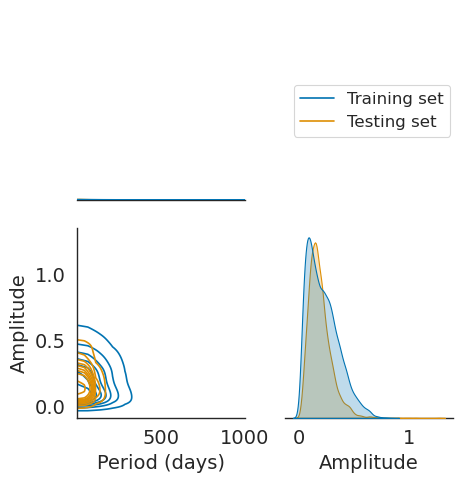

In [ ]:
train_filtered_by_fit_period = train_dataset
print(train_filtered_by_fit_period.shape)
test_filtered_by_fit_period = test_dataset
print(test_filtered_by_fit_period.shape)
plot_2d_density(train_filtered_by_fit_period, test_filtered_by_fit_period, 
                star_class='ECL', sample=10000,  xlim=(2,1000), bw=5)

In [ ]:
train_filtered_by_fit_period = train_dataset[train_dataset.Period_fit<0.05]
train_filtered_by_fit_period[train_filtered_by_fit_period.Type=='ECL'].PeriodLS.quantile([0.1,0.9])

0.1    0.240577
0.9    4.545333
Name: PeriodLS, dtype: float64

In [ ]:
selected_features = ['PeriodLS', 'Amplitude','MedianAbsDev', 'Q31', 'Mean', 'Std', 'Freq1_harmonics_amplitude_0']
d_train = train_dataset[(train_dataset.Type==star_class) & (train_dataset.PeriodLS<train_dataset.PeriodLS.quantile(0.95))][selected_features].sample(1000)
d_test = test_dataset[(test_dataset.Type==star_class)& (test_dataset.PeriodLS<test_dataset.PeriodLS.quantile(0.95))][selected_features]
d_train['set'] = 'Training set'
d_test['set'] = 'Testing set'
data_final = pd.concat([d_train, d_test])
data_final.columns = ['Period', 'Amplitude','MedianAbsDev', 'Q31', 'Mean', 'Std', 'Freq1_harmonics', 'set']
sns.set_theme(style="white")

sns.set_context("paper", rc={"font.size":16, "font_scale":1.25, "axes.titlesize":16,"axes.labelsize":16,
                "xtick.labelsize":16, "ytick.labelsize":16, "legend.fontsize":16, "legend.title_fontsize": 16, 
                            "legend.loc": 'upper center', "alpha":0.2, "figure.dpi":600, 'savefig.dpi':600}) 

plt.figure(figsize=(21, 21), dpi = 900) 
g = sns.PairGrid(data_final, hue='set', palette = 'colorblind', corner=True)
g.map_diag(sns.kdeplot,  shade=True, palette = 'colorblind')
g.map_lower(sns.kdeplot, palette = 'colorblind')
g.map_upper(sns.kdeplot, shade=True, palette = 'colorblind', hue=None)

handles = g._legend_data.values()
labels = g._legend_data.keys()
plt.legend(handles=handles, labels=labels, bbox_to_anchor=(0., 6), ncol=2, borderaxespad=0)

plt.savefig('shift.svg', format='svg', bbox_inches='tight')

In [ ]:
selected_features = ['PeriodLS', 'Amplitude','MedianAbsDev', 'Q31', 'Mean', 'Std', 'Freq1_harmonics_amplitude_0']
d_train = train_dataset[(train_dataset.label=='ClassA') & (train_dataset.PeriodLS<1.5)][selected_features].sample(5000)
d_test = test_dataset[(test_dataset.label=='ClassA')& (test_dataset.PeriodLS<1.5)][selected_features].sample(5000)
d_train['set'] = 'RR Lyrae training set'
d_test['set'] = 'RR Lyrae testing set'
data_final = pd.concat([d_train, d_test])
data_final.columns = ['Period', 'Amplitude','MedianAbsDev', 'Q31', 'Mean', 'Std', 'Freq1_harmonics', 'set']
sns.set_theme(style="white")

sns.set_context("paper", rc={"font.size":16, "font_scale":1.25, "axes.titlesize":16,"axes.labelsize":16,
                "xtick.labelsize":16, "ytick.labelsize":16, "legend.fontsize":16, "legend.title_fontsize": 16, 
                            "legend.loc": 'upper center', "alpha":0.2, "figure.dpi":600, 'savefig.dpi':600}) 

plt.figure(figsize=(21, 21), dpi = 900) 
g = sns.PairGrid(data_final, palette = 'colorblind', corner=True)
g.map_diag(sns.kdeplot,  shade=True, palette = 'colorblind')
g.map_lower(sns.scatterplot, palette = 'colorblind')

plt.savefig('shift-complete.svg', format='svg', bbox_inches='tight')

In [ ]:

PATH_FEATURES_TRAIN = PATHS['PATH_FEATURES_TRAIN']
PATH_FEATURES_TEST = PATHS['PATH_FEATURES_TEST']

lc_test = pd.read_table(PATH_FEATURES_TEST, sep= ',')
lc_train = pd.read_table(PATH_FEATURES_TRAIN, sep= ',')

lc_test['label'] = lc_test['ID']
lc_train['label'] = lc_train['ID']

lc_train =  lc_train.drop(['Pred', 'Pred2', 'h', 'e', 'u', 'ID'], axis = 1)
lc_test =  lc_test.drop(['Pred', 'Pred2', 'h', 'e', 'u', 'ID'], axis = 1)

for col in lc_train.columns:
    if col not in ['label']:
        if lc_train[col].var()==0:
            print(col)
            del lc_train[col]
            
for col in lc_test.columns:
    if col not in ['label']:
        if lc_test[col].var()==0:
            print(col)
            del lc_test[col]

In [ ]:
#lc_train, lc_test = ut.delete_outliers(lc_train, lc_test)

In [ ]:
lc_test['set'] = 'Testing'
lc_train['set'] = 'Training'

In [ ]:
new_train = lc_train['label'].str.split("-", n = 3, expand = True) 
new_test = lc_test['label'].str.split("-", n = 3, expand = True) 

lc_train["Field"]= new_train[1] 
lc_train['Class']= new_train[2]  

lc_test["Field"]= new_test[1] 
lc_test['Class']= new_test[2] 


total_set = pd.concat([lc_train, lc_test])
total_set['count'] = 1

total_set= total_set[['set', 'Class', 'count']].groupby(['set', 'Class']).sum().reset_index()